# Approximation error analysis

In [2]:
import os
while "notebooks" in os.getcwd():
    os.chdir("../")


In [128]:
from pathlib import Path
import pandas as pd
import numpy as np
import json

from src.decision_tree.tree import load_trees
from src.decision_tree.prediction_gap import (
    NormalPredictionGap,
    prediction_gap_on_single_feature_perturbation,
    prediction_gap_by_random_sampling,
    prediction_gap_by_exact_calc,
    rank_features_by_random,
)

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
models_path = Path("models")
data_path = Path("data")
wine_model_name = "winequality_red"
wine_test_data_path = data_path / "wine_quality/test_winequality_red_scaled.csv"
housing_model_name = "housing"
housing_test_data_path = data_path / "housing_data/test_housing_scaled.csv"


In [5]:
stddev = 0.3


## Wczytanie danych i modelu

In [6]:
wine_trees = load_trees(models_path, wine_model_name)


In [7]:
wine_data = pd.read_csv(wine_test_data_path)
wine_data


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,-0.413454,0.123905,-0.313113,-0.240375,-0.349975,-0.848716,-0.561586,-0.183745,-0.201591,-0.638220,-0.678644,5
1,1.310138,-0.937525,1.638205,-0.240375,1.371576,-0.944346,-0.865676,0.982285,-1.756618,2.312434,-0.960246,5
2,-1.160343,2.526090,-1.340122,-0.382271,-0.647527,-0.083669,-0.409542,-0.989366,1.871778,-1.169337,0.729364,6
3,-0.068735,0.598756,-0.877968,-0.311323,-0.307468,0.872638,0.411500,-0.194345,-0.136798,0.542042,0.447763,6
4,-1.217796,-0.490607,0.611196,-0.027532,-0.222453,-0.944346,-0.987312,-0.634256,1.288643,0.187963,0.541630,6
...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.103624,-0.714066,0.662546,2.668484,-0.796303,-1.231239,-1.108948,-0.575955,-0.201591,-0.579207,1.480302,4
316,1.195232,0.626688,-0.159061,0.185312,0.372651,1.255161,0.198638,1.618302,-0.460762,0.069937,-0.490910,5
317,0.103624,-0.323013,-0.005010,-0.453218,-0.626274,0.203223,-0.257497,-0.830361,-0.979104,1.132173,0.635497,6
318,-0.585813,0.347364,-0.056360,-0.382271,-0.158692,0.107592,1.749495,-0.480552,-0.201591,-0.815259,-0.490910,5


In [8]:
housing_trees = load_trees(models_path, housing_model_name)


In [9]:
housing_data = pd.read_csv(housing_test_data_path)
housing_data


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,1.307575,-0.862335,-0.686477,-0.108529,0.019293,0.265378,0.111059,-1.045477,77700.0
1,-1.452618,0.987002,1.856182,-0.215333,-0.272609,-0.312139,-0.338825,0.137031,314300.0
2,-0.993418,1.581599,-0.527561,-0.341390,-0.469583,-0.355408,-0.532380,-0.600266,99100.0
3,-0.878618,1.370915,-0.924851,0.445661,0.342046,0.237120,0.435395,-0.294598,109400.0
4,-1.302879,0.982320,1.141059,-0.570583,-0.581123,-0.503761,-0.561151,-0.711385,76400.0
...,...,...,...,...,...,...,...,...,...
4123,-1.123192,0.809091,0.425936,-0.367518,-0.381775,0.021655,-0.398984,-0.079942,161500.0
4124,0.259400,-0.141327,-0.845393,4.616525,5.095534,4.930548,5.368429,-0.487884,87200.0
4125,0.638740,-0.768697,1.141059,-0.336348,-0.331939,-0.240611,-0.357134,-1.017579,112900.0
4126,0.598809,-0.675060,-0.765935,0.116539,0.671918,0.686594,0.537403,-0.632217,185100.0


Zauważyłem że w zbiorze housing niecałe 1% datapointów ma brakujące wartości w kolumnie `total_bedrooms`. Wyrzucam te wiersze.

In [10]:
sample_housing_data = housing_data[housing_data["total_bedrooms"].notna()].sample(n=200, random_state=42)
sample_housing_data


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
603,0.598809,-0.834244,0.028646,0.470414,0.114220,0.177073,0.291536,1.330014,410000.0
758,-0.973452,1.801647,-0.607019,-0.003558,-0.104113,-0.054287,-0.082495,-0.960730,59400.0
2036,0.638740,-0.773379,1.061601,0.090411,0.546140,0.985949,0.589716,-1.327931,100000.0
1009,-1.352792,0.991684,-0.686477,-0.678304,-0.410254,-0.743952,-0.453912,-0.354500,100000.0
3597,0.693644,-0.824880,0.743768,0.012943,0.209147,0.177956,0.273227,-0.062097,161900.0
...,...,...,...,...,...,...,...,...,...
2726,-0.349539,-0.426921,-1.163225,-0.617339,-0.619094,-0.646816,-0.686701,-0.323076,230800.0
2441,-1.502531,1.099367,1.856182,-0.667303,-0.763858,-0.846386,-0.791325,0.574188,292200.0
1881,-1.367766,0.902729,0.902685,-0.588919,-0.493315,-0.639751,-0.529764,-0.289861,292900.0
2641,-1.821975,1.651827,0.028646,1.597588,1.623565,1.915804,1.803357,-0.652535,109600.0


# Winequality

## Prediction gap dla każdego featura osobno

Widzimy że kolejność zwracana przez wersje `abs` oraz `squared` jest bardzo podobna, choć nie identyczna.

In [119]:
predgap = NormalPredictionGap(stddev)


In [12]:
%%time
single_abs_predgaps = prediction_gap_on_single_feature_perturbation(
    predgap, wine_trees, wine_data, squared=False)


Starting predgap calculation for alcohol.
Starting predgap calculation for sulphates.
Starting predgap calculation for volatile_acidity.
Starting predgap calculation for fixed_acidity.
Starting predgap calculation for residual_sugar.
Starting predgap calculation for free_sulfur_dioxide.
Starting predgap calculation for total_sulfur_dioxide.
Starting predgap calculation for citric_acid.
Starting predgap calculation for chlorides.
Starting predgap calculation for pH.
Starting predgap calculation for density.
CPU times: user 16.6 s, sys: 1.61 s, total: 18.2 s
Wall time: 16.2 s


In [13]:
single_abs_predgaps


,Feature,PredGap
0,alcohol,0.073881
1,sulphates,0.071879
6,total_sulfur_dioxide,0.062929
2,volatile_acidity,0.060902
8,chlorides,0.057954
4,residual_sugar,0.051040
9,pH,0.043871
7,citric_acid,0.043363
10,density,0.041174
5,free_sulfur_dioxide,0.040571


In [14]:
%%time
single_sqr_predgaps = prediction_gap_on_single_feature_perturbation(
    predgap, wine_trees, wine_data, squared=True)


Starting predgap calculation for alcohol.
Starting predgap calculation for sulphates.
Starting predgap calculation for volatile_acidity.
Starting predgap calculation for fixed_acidity.
Starting predgap calculation for residual_sugar.
Starting predgap calculation for free_sulfur_dioxide.
Starting predgap calculation for total_sulfur_dioxide.
Starting predgap calculation for citric_acid.
Starting predgap calculation for chlorides.
Starting predgap calculation for pH.
Starting predgap calculation for density.
CPU times: user 16.3 s, sys: 1.68 s, total: 18 s
Wall time: 16.2 s


In [15]:
single_sqr_predgaps


,Feature,PredGap
0,alcohol,0.014450
1,sulphates,0.012749
6,total_sulfur_dioxide,0.010269
2,volatile_acidity,0.009352
8,chlorides,0.009064
4,residual_sugar,0.007608
9,pH,0.005261
7,citric_acid,0.004806
5,free_sulfur_dioxide,0.004726
10,density,0.004648


In [16]:
two_best_features = set(single_sqr_predgaps["Feature"][:2])
all_but_two_worst_features = set(single_sqr_predgaps["Feature"][:-2])
all_features = set(single_sqr_predgaps["Feature"])


In [17]:
def rmse(y_pred, y_exact) -> float:
    return np.sqrt(((y_pred - y_exact) ** 2).mean())


In [18]:
%%time
all_features_1000_iter_random_results = prediction_gap_by_random_sampling(
    wine_trees, wine_data, all_features, stddev=stddev, squared=True, num_iter=1000)


There are 320 datapoints in the dataset.
The following 11 features are subject to perturbation:
{'alcohol', 'sulphates', 'volatile_acidity', 'fixed_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'pH', 'citric_acid', 'chlorides', 'free_sulfur_dioxide', 'density'}
Starting prediction gap calculation by random sampling with 1000 iterations.
CPU times: user 2min 49s, sys: 26.3 ms, total: 2min 49s
Wall time: 2min 50s


In [19]:
%%time
all_features_10000_iter_random_results = prediction_gap_by_random_sampling(
    wine_trees, wine_data, all_features, stddev=stddev, squared=True, num_iter=10000)


There are 320 datapoints in the dataset.
The following 11 features are subject to perturbation:
{'alcohol', 'sulphates', 'volatile_acidity', 'fixed_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'pH', 'citric_acid', 'chlorides', 'free_sulfur_dioxide', 'density'}
Starting prediction gap calculation by random sampling with 10000 iterations.
CPU times: user 28min 17s, sys: 883 ms, total: 28min 18s
Wall time: 28min 20s


In [96]:
type(all_features_10000_iter_random_results)

numpy.ndarray

In [105]:
save_path = Path("results/wine_all_features_10000_iter.npy")


In [106]:
with open(save_path, "wb") as wf:
    np.save(wf, all_features_10000_iter_random_results)


In [107]:
with open(save_path, "rb") as rf:
    tmp = np.load(rf)
    

In [110]:
all(tmp == all_features_10000_iter_random_results)


True

In [125]:
all_features = {'alcohol', 'sulphates', 'volatile_acidity', 'fixed_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'pH', 'citric_acid', 'chlorides', 'free_sulfur_dioxide', 'density'}

In [126]:
%%time
all_features_exact_result_wine = prediction_gap_by_exact_calc(
    predgap, wine_trees, wine_data, all_features, squared=True, processes=80)


There are 320 datapoints in the dataset.
The following 11 features are subject to perturbation:
{'alcohol', 'sulphates', 'volatile_acidity', 'fixed_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'pH', 'citric_acid', 'chlorides', 'free_sulfur_dioxide', 'density'}
Starting exact prediction gap calculation.
Datapoint 56 returned predgap value of 0.003935377205954788.
Datapoint 20 returned predgap value of 0.003216524218360501.
Datapoint 1 returned predgap value of 0.03517494182828179.
Datapoint 44 returned predgap value of 0.023764390947293247.
Datapoint 40 returned predgap value of 0.027617584848412556.
Datapoint 76 returned predgap value of 0.04430469795808436.
Datapoint 41 returned predgap value of 0.015774397936776412.
Datapoint 16 returned predgap value of 0.06043642707492315.
Datapoint 29 returned predgap value of 0.021760436672778632.
Datapoint 2 returned predgap value of 0.18684580628418057.
Datapoint 78 returned predgap value of 0.025819037806990627.
Datapoint 54 returned pr

In [127]:
save_path = Path("results/wine_all_features_exact.npy")
with open(save_path, "wb") as wf:
    np.save(wf, all_features_exact_result_wine)


In [24]:
import matplotlib.pyplot as plt


<Axes: >

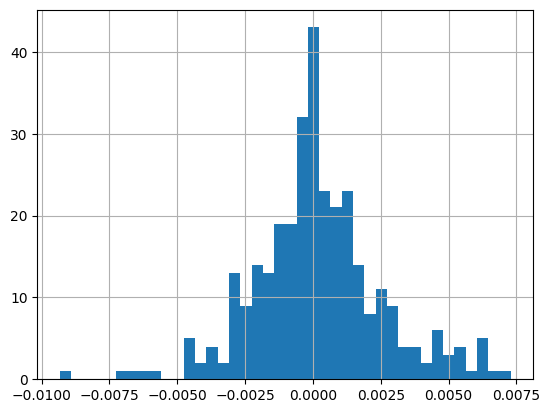

In [25]:
diff_ser = pd.Series(all_features_1000_iter_random_results - all_features_exact_result)
diff_ser.hist(bins=40)


In [26]:
rmse(all_features_1000_iter_random_results, all_features_exact_result)


0.0023854175592002203

In [27]:
thr = 0.005
len(diff_ser[diff_ser.abs() > thr])


18

In [28]:
all_features_exact_result[diff_ser.abs() > thr]

array([0.12169032, 0.10056816, 0.10194849, 0.09873394, 0.11613652,
       0.08014919, 0.08471426, 0.0624219 , 0.10370533, 0.05540186,
       0.07932113, 0.14629175, 0.05674523, 0.11853524, 0.10830057,
       0.0882034 , 0.12552651, 0.10460494])

In [29]:
all_features_1000_iter_random_results[diff_ser.abs() > thr]

array([0.12786739, 0.10672015, 0.10838417, 0.10400477, 0.10963785,
       0.0857043 , 0.07890073, 0.05632325, 0.10988516, 0.06142778,
       0.08487254, 0.15313121, 0.06190419, 0.12481924, 0.10141611,
       0.09356904, 0.11619858, 0.11189638])

In [30]:
all_features_exact_result.mean()

0.04914593626663617

In [31]:
pd.Series(all_features_exact_result).quantile(np.linspace(0.0, 1.0, 21))

0.00    0.003217
0.05    0.009858
0.10    0.015421
0.15    0.019751
0.20    0.022376
0.25    0.025809
0.30    0.027652
0.35    0.030367
0.40    0.032921
0.45    0.036614
0.50    0.038579
0.55    0.041792
0.60    0.045159
0.65    0.051258
0.70    0.056226
0.75    0.061567
0.80    0.070325
0.85    0.080486
0.90    0.096509
0.95    0.119523
1.00    0.270561
dtype: float64

Większy błąd przybliżenia obserwujemy przy większych wartościach prediction gap.

In [32]:
rel_diff_ser = pd.Series((all_features_1000_iter_random_results - all_features_exact_result)/all_features_exact_result)


<Axes: >

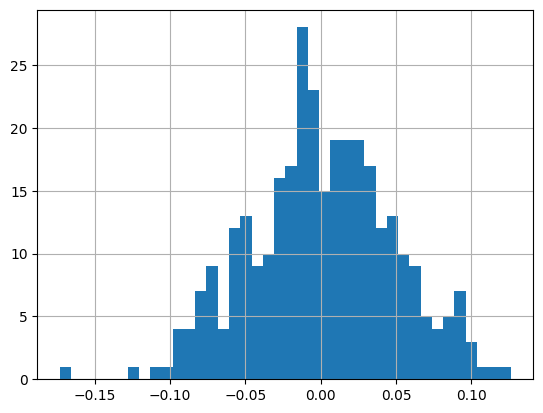

In [33]:
rel_diff_ser.hist(bins=40)

In [44]:
len(rel_diff_ser[rel_diff_ser.abs() > 0.0911])


18

In [45]:
all_features_exact_result[rel_diff_ser.abs() > 0.0911]

array([0.02172144, 0.02724131, 0.02581904, 0.028545  , 0.05043354,
       0.03667152, 0.02914608, 0.0624219 , 0.02151757, 0.05540186,
       0.026397  , 0.05055141, 0.01411376, 0.02583303, 0.02599702,
       0.00742908, 0.01980438, 0.04121103])

Z kolei większy błąd względny przybliżenia obserwujemy przy mniejszych wartościach prediction gap.

In [47]:
diff_ser[rel_diff_ser.abs() > 0.0911]

26     0.002018
68     0.002482
78     0.002485
104   -0.002732
113    0.004939
133    0.003797
139   -0.003685
166   -0.006099
168   -0.002033
186    0.006026
197    0.003334
198    0.004624
215   -0.001320
244   -0.002795
250   -0.002747
258   -0.001287
280    0.001922
290    0.004591
dtype: float64

In [48]:
diff_ser[diff_ser.abs() > thr]

18     0.006177
37     0.006152
39     0.006436
49     0.005271
97    -0.006499
142    0.005555
159   -0.005814
166   -0.006099
173    0.006180
186    0.006026
217    0.005551
227    0.006839
228    0.005159
259    0.006284
269   -0.006884
288    0.005366
305   -0.009328
313    0.007291
dtype: float64

In [49]:
all_features_exact_result[(rel_diff_ser.abs() > 0.0911) & (diff_ser.abs() > thr)]

array([0.0624219 , 0.05540186])

In [50]:
huge_diff_df = wine_data[diff_ser.abs() > 0.005]
huge_diff_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
18,-0.930531,2.861279,-0.980669,-0.169427,-0.434990,0.298854,-0.439951,-0.141344,1.353436,-0.520193,0.541630,4
37,1.884668,-1.663767,1.535504,-0.524166,-0.286214,-1.231239,-1.169766,0.717279,-1.108690,0.246977,-0.490910,6
39,1.080326,-1.049255,1.073350,-0.311323,-0.753796,-1.039977,-1.139357,-1.148370,-0.719933,0.187963,1.574170,7
49,0.850513,-1.552038,1.124700,0.114364,0.011338,-0.083669,-0.409542,0.770280,0.705508,1.427238,-0.397043,6
97,-1.275249,0.291499,-0.210412,-0.027532,-0.923826,0.011961,0.715590,-1.710184,0.964679,-0.048089,1.949639,6
142,1.252685,-0.099554,1.894957,-0.098479,0.415159,-0.944346,-0.956903,0.293268,-1.432654,0.010924,1.292568,7
159,-0.758172,1.548457,-1.391472,-0.027532,-0.413736,-0.848716,-0.804858,0.081262,1.094265,-0.579207,-0.772512,5
166,2.114480,-0.434742,1.432803,-0.382271,-0.307468,0.872638,0.077002,1.565300,-1.367861,0.601055,-0.115441,6
173,1.195232,-0.825796,0.970649,-0.311323,0.351398,-0.944346,-1.108948,-0.056541,-1.238276,-0.048089,1.292568,7
186,1.425044,-0.323013,0.816598,-0.311323,1.775397,1.063900,0.593954,0.770280,-0.914312,0.601055,0.353895,6


In [53]:
all_features_10000_iter_huge_diff = all_features_10000_iter_random_results[diff_ser.abs() > 0.005]


In [54]:
all_features_10000_iter_huge_diff

array([0.11859724, 0.10078568, 0.10204274, 0.09728712, 0.11530208,
       0.08066764, 0.08530303, 0.06183301, 0.10323203, 0.05491958,
       0.07981188, 0.1473865 , 0.0571543 , 0.12056079, 0.10820261,
       0.08738164, 0.12419318, 0.10675617])

In [55]:
all_features_exact_result[diff_ser.abs() > thr]

array([0.12169032, 0.10056816, 0.10194849, 0.09873394, 0.11613652,
       0.08014919, 0.08471426, 0.0624219 , 0.10370533, 0.05540186,
       0.07932113, 0.14629175, 0.05674523, 0.11853524, 0.10830057,
       0.0882034 , 0.12552651, 0.10460494])

In [56]:
diff_ser[diff_ser.abs() > thr]

18     0.006177
37     0.006152
39     0.006436
49     0.005271
97    -0.006499
142    0.005555
159   -0.005814
166   -0.006099
173    0.006180
186    0.006026
217    0.005551
227    0.006839
228    0.005159
259    0.006284
269   -0.006884
288    0.005366
305   -0.009328
313    0.007291
dtype: float64

In [57]:
all_features_10000_iter_huge_diff - all_features_exact_result[diff_ser.abs() > thr]

array([-3.09308164e-03,  2.17527033e-04,  9.42491646e-05, -1.44681295e-03,
       -8.34445108e-04,  5.18445987e-04,  5.88767070e-04, -5.88885340e-04,
       -4.73297833e-04, -4.82273152e-04,  4.90747147e-04,  1.09474310e-03,
        4.09078071e-04,  2.02555439e-03, -9.79601866e-05, -8.21763268e-04,
       -1.33333157e-03,  2.15123520e-03])

In [58]:
results_df = pd.DataFrame({"1000_iter": diff_ser[diff_ser.abs() > thr], "10000_iter": all_features_10000_iter_huge_diff - all_features_exact_result[diff_ser.abs() > thr]})

In [59]:
results_df["ratio"] = results_df["10000_iter"] / results_df["1000_iter"]

In [60]:
results_df

,1000_iter,10000_iter,ratio
18,0.006177,-0.003093,-0.500736
37,0.006152,0.000218,0.035359
39,0.006436,0.000094,0.014645
49,0.005271,-0.001447,-0.274494
97,-0.006499,-0.000834,0.128402
142,0.005555,0.000518,0.093328
159,-0.005814,0.000589,-0.101275
166,-0.006099,-0.000589,0.096560
173,0.006180,-0.000473,-0.076588
186,0.006026,-0.000482,-0.080033


In [66]:
huge_rel_diff_df = wine_data[rel_diff_ser.abs() > 0.0911]

In [67]:
huge_rel_diff_df


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
26,-0.930531,0.626688,-0.210412,-0.311323,-0.158692,-0.466193,2.205630,-0.724359,0.316751,0.246977,0.447763,5
68,-0.183641,0.514959,0.303093,0.114364,0.011338,0.011961,-0.287906,0.240266,-0.007213,-0.461180,0.260028,6
78,-0.930531,-1.384443,0.046341,-0.098479,-1.603945,1.924577,1.627859,-3.236624,-0.331177,-1.582429,1.198701,7
104,0.907967,0.068040,0.919299,-0.169427,-0.349975,0.011961,-0.196679,1.247292,0.511130,-0.225128,-0.960246,5
113,-0.241094,-1.049255,0.765247,-0.382271,-0.031169,-0.753085,-0.835267,-0.681958,0.251958,-0.343154,0.917099,6
133,1.597403,-1.216849,1.330102,-0.240375,-0.583766,-1.231239,-1.108948,-0.544154,-1.886203,1.014147,0.447763,7
139,-0.585813,-1.049255,0.303093,-0.027532,-0.498751,0.490115,-0.287906,-0.819761,0.251958,0.660068,1.574170,7
166,2.114480,-0.434742,1.432803,-0.382271,-0.307468,0.872638,0.077002,1.565300,-1.367861,0.601055,-0.115441,6
168,1.195232,-0.490607,2.357111,2.845854,-0.286214,2.115838,0.898044,1.194291,-0.914312,1.132173,1.480302,7
186,1.425044,-0.323013,0.816598,-0.311323,1.775397,1.063900,0.593954,0.770280,-0.914312,0.601055,0.353895,6


In [68]:
all_features_10000_iter_huge_rel_diff = all_features_10000_iter_random_results[rel_diff_ser.abs() > 0.0911]

In [69]:
rel_results_df = pd.DataFrame({"1000_iter": diff_ser[rel_diff_ser.abs() > 0.0911], "10000_iter": all_features_10000_iter_huge_rel_diff - all_features_exact_result[rel_diff_ser.abs() > 0.0911]})

In [70]:
rel_results_df["ratio"] = rel_results_df["10000_iter"] / rel_results_df["1000_iter"]

In [71]:
rel_results_df

,1000_iter,10000_iter,ratio
26,0.002018,0.000344,0.170632
68,0.002482,-0.000560,-0.225728
78,0.002485,0.000013,0.005169
104,-0.002732,-0.000176,0.064339
113,0.004939,0.000630,0.127509
133,0.003797,-0.000019,-0.004920
139,-0.003685,0.000928,-0.251973
166,-0.006099,-0.000589,0.096560
168,-0.002033,0.000085,-0.041566
186,0.006026,-0.000482,-0.080033


In [72]:
predgap

In [73]:
dp = wine_data.iloc[74, :-1]

In [74]:
dp_with_label = wine_data.iloc[74]

In [75]:
dp_with_label

fixed_acidity           1.425044
volatile_acidity       -1.160984
citric_acid             0.867948
residual_sugar         -0.666062
chlorides              -0.520005
free_sulfur_dioxide     0.011961
total_sulfur_dioxide   -0.287906
density                 0.929284
pH                     -0.590348
sulphates               0.719081
alcohol                -0.397043
quality                 6.000000
Name: 74, dtype: float64

In [76]:
wine_trees.eval(dp)

6.0922427

In [77]:
set(dp.index)

{'alcohol',
 'chlorides',
 'citric_acid',
 'density',
 'fixed_acidity',
 'free_sulfur_dioxide',
 'pH',
 'residual_sugar',
 'sulphates',
 'total_sulfur_dioxide',
 'volatile_acidity'}

In [78]:
%%time
res = predgap.rank_features(wine_trees, dp)


Rank 1: alcohol.
Rank 2: volatile_acidity.
Rank 3: total_sulfur_dioxide.
Rank 4: pH.
Rank 5: chlorides.
Rank 6: sulphates.
Rank 7: citric_acid.
Rank 8: free_sulfur_dioxide.
Rank 9: density.
Rank 10: residual_sugar.
CPU times: user 6min 11s, sys: 16.8 s, total: 6min 28s
Wall time: 6min 7s


In [79]:
res

['alcohol',
 'volatile_acidity',
 'total_sulfur_dioxide',
 'pH',
 'chlorides',
 'sulphates',
 'citric_acid',
 'free_sulfur_dioxide',
 'density',
 'residual_sugar',
 'fixed_acidity']

In [82]:
dp.index

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')

In [91]:
%%time
res_random = rank_features_by_random(wine_trees, dp, stddev=stddev, num_iter=1000)


alcohol 0.033966443977920334
sulphates 0.007981490864795205
volatile_acidity 0.02331557204283604
fixed_acidity 0.000263566268168006
residual_sugar 0.0010344417922660797
free_sulfur_dioxide 8.866417521085168e-05
total_sulfur_dioxide 0.012691021504038872
citric_acid 0.0002299287426030787
chlorides 0.001050330865257365
pH 0.00035827580559271154
density 0.0002171598551592524
Rank 1: alcohol.
sulphates 0.038774835217871895
volatile_acidity 0.05516422621919287
fixed_acidity 0.04190057841810244
residual_sugar 0.03673964269442831
free_sulfur_dioxide 0.034978571500753335
total_sulfur_dioxide 0.04313901893657317
citric_acid 0.033500140373356774
chlorides 0.03762734724822599
pH 0.0379100021196698
density 0.03622563371469141
Rank 2: volatile_acidity.
sulphates 0.05938469512513393
fixed_acidity 0.06318120063320726
residual_sugar 0.05596236552738492
free_sulfur_dioxide 0.053977287487023205
total_sulfur_dioxide 0.06807945341478308
citric_acid 0.05501875126209734
chlorides 0.054786318802914596
pH 0.05

In [88]:
res_random

['alcohol',
 'volatile_acidity',
 'total_sulfur_dioxide',
 'sulphates',
 'fixed_acidity',
 'chlorides',
 'free_sulfur_dioxide',
 'citric_acid',
 'pH',
 'density',
 'residual_sugar']

In [95]:
%%time
res = predgap.rank_features(wine_trees, dp)


alcohol 0.05089353291416385
sulphates 0.006610958108928203
volatile_acidity 0.03087239972516486
fixed_acidity 0.0013133759387966258
residual_sugar 0.0031441329513464365
free_sulfur_dioxide 0.0011153087724125581
total_sulfur_dioxide 0.00968387397115509
citric_acid 0.0012637609262002845
chlorides 0.005109483627551162
pH 0.00259984425916356
density 0.0012933674472857693
Rank 1: alcohol.
sulphates 0.05260270897023702
volatile_acidity 0.0726918405488691
fixed_acidity 0.04221228750703385
residual_sugar 0.05692179976119558
free_sulfur_dioxide 0.04933758469500276
total_sulfur_dioxide 0.061439974386090244
citric_acid 0.049585339614015386
chlorides 0.05366047304753755
pH 0.05381398455897993
density 0.04991905157010926
Rank 2: volatile_acidity.
sulphates 0.0756758297095063
fixed_acidity 0.06347633057667032
residual_sugar 0.07282975731880618
free_sulfur_dioxide 0.07092238869285922
total_sulfur_dioxide 0.08576270412232306
citric_acid 0.07090027379245725
chlorides 0.0763166770394275
pH 0.07643892528

Ciekawe że wyniki nie są monotoniczne (mam na myśli że nie zawsze wyniki z danej grupy są wyższe niż wszystkie wyniki poprzedniej grupy).

In [111]:
%%time
single_sqr_predgaps = prediction_gap_on_single_feature_perturbation(
    predgap, housing_trees, sample_housing_data, squared=True)


Starting predgap calculation for population.
Starting predgap calculation for total_bedrooms.
Starting predgap calculation for total_rooms.
Starting predgap calculation for longitude.
Starting predgap calculation for median_income.
Starting predgap calculation for latitude.
Starting predgap calculation for households.
Starting predgap calculation for housing_median_age.
CPU times: user 27.7 s, sys: 1.7 s, total: 29.4 s
Wall time: 27.1 s


In [112]:
single_sqr_predgaps


,Feature,PredGap
5,latitude,3.779477e+09
3,longitude,3.231851e+09
4,median_income,4.890728e+08
0,population,3.350571e+08
1,total_bedrooms,2.193683e+08
7,housing_median_age,6.371490e+07
6,households,4.692505e+07
2,total_rooms,3.840330e+07


In [113]:
all_features = set(single_sqr_predgaps["Feature"])


In [115]:
%%time
all_features_100_iter_random_results = prediction_gap_by_random_sampling(
    housing_trees, sample_housing_data, all_features, stddev=stddev, squared=True, num_iter=100)


There are 200 datapoints in the dataset.
The following 8 features are subject to perturbation:
{'population', 'total_bedrooms', 'total_rooms', 'longitude', 'median_income', 'latitude', 'households', 'housing_median_age'}
Starting prediction gap calculation by random sampling with 100 iterations.
CPU times: user 28.7 s, sys: 3.67 ms, total: 28.7 s
Wall time: 28.8 s


In [116]:
%%time
all_features_1000_iter_random_results = prediction_gap_by_random_sampling(
    housing_trees, sample_housing_data, all_features, stddev=stddev, squared=True, num_iter=1000)


There are 200 datapoints in the dataset.
The following 8 features are subject to perturbation:
{'population', 'total_bedrooms', 'total_rooms', 'longitude', 'median_income', 'latitude', 'households', 'housing_median_age'}
Starting prediction gap calculation by random sampling with 1000 iterations.
CPU times: user 4min 45s, sys: 214 ms, total: 4min 46s
Wall time: 4min 46s


In [120]:
%%time
all_features_exact_result = prediction_gap_by_exact_calc(
    predgap, housing_trees, sample_housing_data, all_features, squared=True, processes=80)


There are 200 datapoints in the dataset.
The following 8 features are subject to perturbation:
{'population', 'total_bedrooms', 'total_rooms', 'longitude', 'median_income', 'latitude', 'households', 'housing_median_age'}
Starting exact prediction gap calculation.
Datapoint 22 returned predgap value of 10389822272.360466.
Datapoint 73 returned predgap value of 7938398758.815225.
Datapoint 17 returned predgap value of 1018037292.3012873.
Datapoint 67 returned predgap value of 4440003631.350313.
Datapoint 56 returned predgap value of 2942634188.398351.
Datapoint 9 returned predgap value of 4519365478.669474.
Datapoint 45 returned predgap value of 5752710457.64016.
Datapoint 78 returned predgap value of 4491333438.963966.
Datapoint 21 returned predgap value of 2199242713.457401.
Datapoint 55 returned predgap value of 780276767.1909173.
Datapoint 40 returned predgap value of 8386942069.960933.
Datapoint 1 returned predgap value of 1643872493.9395702.
Datapoint 65 returned predgap value of 1

In [121]:
save_path = Path("results/housing_all_features_exact.npy")
with open(save_path, "wb") as wf:
    np.save(wf, all_features_exact_result)


In [122]:
%%time
all_features_10000_iter_random_results = prediction_gap_by_random_sampling(
    housing_trees, sample_housing_data, all_features, stddev=stddev, squared=True, num_iter=10000)


There are 200 datapoints in the dataset.
The following 8 features are subject to perturbation:
{'population', 'total_bedrooms', 'total_rooms', 'longitude', 'median_income', 'latitude', 'households', 'housing_median_age'}
Starting prediction gap calculation by random sampling with 10000 iterations.
CPU times: user 49min 48s, sys: 1.22 s, total: 49min 50s
Wall time: 49min 53s


In [123]:
save_path = Path("results/housing_all_features_10000_iter.npy")
with open(save_path, "wb") as wf:
    np.save(wf, all_features_10000_iter_random_results)
